In [1]:
import matplotlib.dates as mdates
from datetime import timedelta
import time, sys
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from matplotlib import cm

# How do the ICON and CLaMS-ice total water values compare (no time dimension)?
### One-to-one plot

In [2]:
# CLaMS and corresponding ICON trajectory files
filenum = '001'
#basedir = '/work/bb1018/b380873/traj_output/test2h/'
basedir_icon = '/work/bb1018/b380873/traj_output/full51h_fast/51h_trim/'
basedir_clams = '/work/bb1018/b380873/traj_output/full51h_fast/51h_clams/'
icon = xr.open_dataset(basedir_icon + 'traj_tst00000450_p' + filenum + '_trim.nc')
clams = xr.open_dataset(basedir_clams + 'cirrus_tst00000450_p' + filenum + '_trim_clams.nc')
clams = clams.rename({'T':'temp'})

In [18]:
# CLaMS time values - numpy.datetime64
clams_t = clams.time.values

# Convert ICON time to datetime64 as well, using the simulation restart time.
sim_start = np.datetime64('2017-08-06T06:00:00.000000000')
icon_t = sim_start + [np.timedelta64(int(i),'s') for i in icon.rtime.values[:7651]]

In [19]:
# CLaMS mixing ratios
clams_qv = clams.Q         # kg kg-1, vapor mass mixing ratio
clams_qi = clams.IWC_hom + clams.IWC_het + clams.IWC_pre

# Total water in CLaMS is vapor + ice.
clams_tot_water = (clams_qv + clams_qi).values
# Dims = time 120, NPARTS 5433 for 2-hour test
# Dims = time 7651, NPARTS 244 for 51-hour full

# ICON mixing ratios - truncate at 7651 values
icon_qv = icon.qv    # kg kg-1, vapor mass mixing ratio
icon_qi = icon.qi + icon.qs + icon.qg   # kg kg-1, frozen hydrometeor mass mixing ratio
icon_qc = icon.qc

# Total water in CLaMS is vapor + ice hydrometeors + droplets.
icon_tot_water = (icon_qv + icon_qi + icon_qc).values[:7651]
# Dims = time_step 300, traj_id 5433 for 2-hour test
# Dims = time_step 7651, NPARTS 244 for 51-hour full

In [20]:
# Read in ICON temperatures and put NaNs where it is warmer than 237 K.
icon_temp = icon.t.values[:7651]
icon_tot_water[icon_temp > 237] = np.nan

In [21]:
# How many of the CLaMS / ICON trajectories now contain all nans?
nan_or_not = []
for i in np.arange(clams_tot_water.shape[1]):
    nan_or_not.append(np.isnan(clams_tot_water[:,i]).all())
print('Percentage of CLaMS trajectories with all nans: ' + str(sum(nan_or_not)/clams_tot_water.shape[1]*100.) + '%')

nan_or_not = []
for i in np.arange(icon_tot_water.shape[1]):
    nan_or_not.append(np.isnan(icon_tot_water[:,i]).all())
print('Percentage of ICON trajectories with all nans: ' + str(sum(nan_or_not)/clams_tot_water.shape[1]*100.) + '%')

Percentage of CLaMS trajectories with all nans: 76.22950819672131%
Percentage of ICON trajectories with all nans: 0.0%


Text(0, 0.5, 'ICON total water [g kg$^{-1}$]')

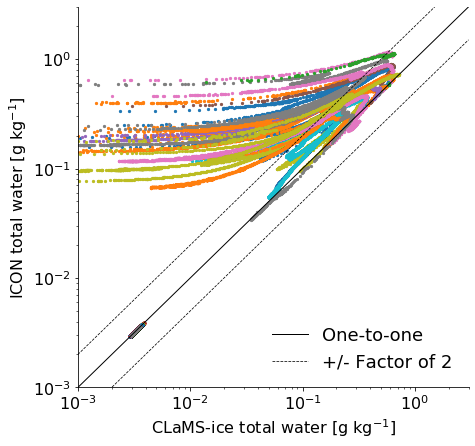

In [22]:
fs = 16
#colors = plt.cm.jet(np.linspace(0,1,24))
#c = 0

fig = plt.figure(figsize=(7,7))
down = 10**(-3); up = 3
plt.plot(np.linspace(down,up,100),np.linspace(down,up,100),color='k',lw=1,label='One-to-one')
plt.plot(np.linspace(down,up,100),2*np.linspace(down,up,100),color='k',linestyle='--',lw=0.75,label='+/- Factor of 2')
plt.plot(np.linspace(down,up,100),0.5*np.linspace(down,up,100),color='k',linestyle='--',lw=0.75)

for i in np.arange(clams_tot_water.shape[1]):
    if ~np.isnan(clams_tot_water[:,i]).all():
        plt.scatter(clams_tot_water[:,i]*10**3,icon_tot_water[:,i]*10**3,s=5,label='__nolabel__')   # icon_tot_water_cubic[:,i]
        #c=colors[c] above, c = c + 1
        # Factor of 10**3 converts to g per kg

plt.gca().tick_params('both',labelsize=fs)
plt.xlim([down,up])
plt.ylim([down,up])
plt.xscale('log')
plt.yscale('log')
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none')
plt.legend(fontsize=fs+2,loc='lower right',frameon=False)
plt.xlabel('CLaMS-ice total water [g kg$^{-1}$]',fontsize=fs)
plt.ylabel('ICON total water [g kg$^{-1}$]',fontsize=fs)

#fig.savefig('../output/tot-water-full51h-OnetoOne5.png',bbox_inches='tight')

# How do ICON and CLaMS-ice total water diverge over time?
### Relative difference plot

Text(0, 0.5, 'ICON-CLaMS-ice difference \nin total water [g kg$^{-1}$]')

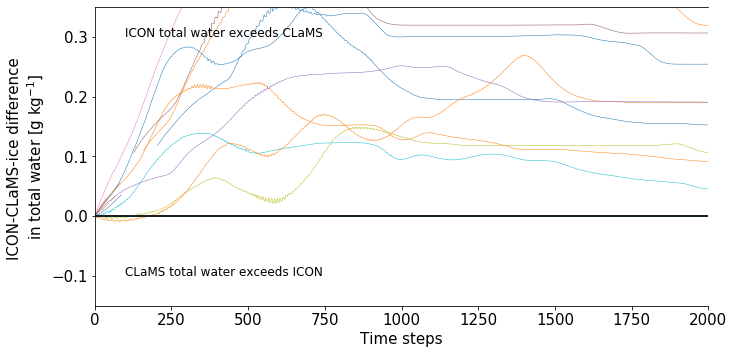

In [23]:
fs = 15
endtime = 2000

fig = plt.figure(figsize=(11,5.5))
for i in np.arange(200):#clams_tot_water.shape[1]):
    if ~np.isnan(clams_tot_water[:,i]).all():
        plt.plot((icon_tot_water[:,i] - clams_tot_water[:,i])*10**3,lw=0.5,label='__nolabel__')  #icon_tot_water_cubic[:,i] 
        # Previously normalized the above like /clams_tot_water[:,i]*100.

#print()
plt.plot([0,endtime],[0,0],color='k',lw=1.5)
plt.text(0.05,0.9,'ICON total water exceeds CLaMS',fontsize=12,transform=plt.gca().transAxes)
plt.text(0.05,0.1,'CLaMS total water exceeds ICON',fontsize=12,transform=plt.gca().transAxes)
plt.gca().tick_params('both',labelsize=fs)
plt.gca().spines['right'].set_color('none')
plt.xlim([0,endtime])
plt.ylim([-0.15,0.35]) #plt.ylim([-50,50])
plt.xlabel('Time steps',fontsize=fs)
plt.ylabel('ICON-CLaMS-ice difference '  # relative [%]
           '\n'
           r'in total water [g kg$^{-1}$]',fontsize=fs)
#fig.savefig('../output/tot-water-RelDiff5png',bbox_inches='tight')

# How much does phase-separated water diverge over time? i.e. ice water or water vapor
## One-to-one and relative difference plots

In [14]:
# Extract the values for CLaMS and ICON ice and vapor mixing ratios
clams_qv = clams_qv.values
clams_qi = clams_qi.values
icon_qv = icon_qv.values
icon_qi = icon_qi.values

# Filter the ICON ice and vapor mr only for temperatures colder than 237 K
icon_qv[icon_temp > 237] = np.nan
icon_qi[icon_temp > 237] = np.nan

# Interpolate the ICON ice and vapor mr to the CLaMS-ice ones.
icon_qv_cubic = np.zeros((clams_qv.shape))
icon_qi_cubic = np.zeros((clams_qi.shape))

# For each trajectory
for i in np.arange(clams_qi.shape[1]):
    cubic_interp = interp1d(icon_t,icon_qi[:,i],kind='cubic')
    icon_qi_cubic[:,i] = cubic_interp(clams_t)
    
for i in np.arange(clams_qv.shape[1]):
    cubic_interp = interp1d(icon_t,icon_qv[:,i],kind='cubic')
    icon_qv_cubic[:,i] = cubic_interp(clams_t)

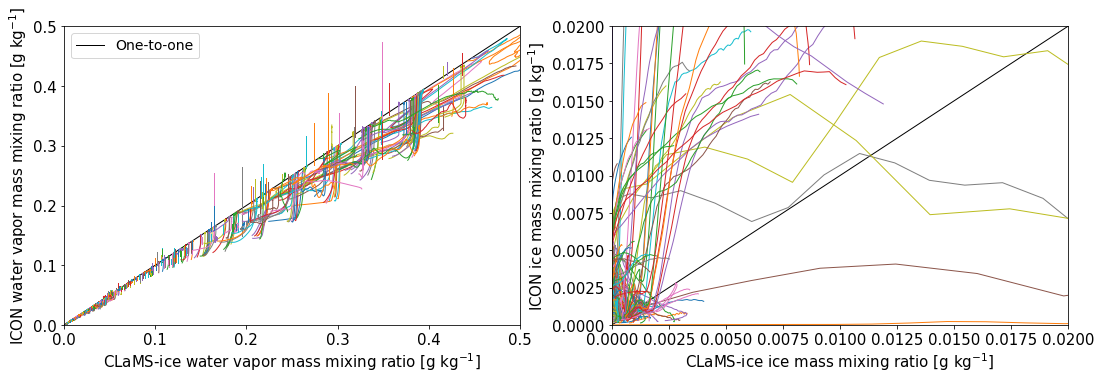

In [113]:
fs = 15
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,5.5))
down = 0; up = 0.5
ax[0].plot(np.linspace(down,up,100),np.linspace(down,up,100),color='k',lw=1,label='One-to-one')
for i in np.arange(2500):
    ax[0].plot(clams_qv[:,i]*10**3,icon_qv_cubic[:,i]*10**3,lw=1,label='__nolabel__')
    # Factor of 10**3 converts to g per kg

ax[0].tick_params('both',labelsize=fs)
ax[0].set_xlim([down,up])
ax[0].set_ylim([down,up])
ax[0].legend(fontsize=14,loc='upper left')
ax[0].set_xlabel('CLaMS-ice water vapor mass mixing ratio [g kg$^{-1}$]',fontsize=fs)
ax[0].set_ylabel('ICON water vapor mass mixing ratio [g kg$^{-1}$]',fontsize=fs)

down = 0; up = 0.02
ax[1].plot(np.linspace(down,up,100),np.linspace(down,up,100),color='k',lw=1,label='One-to-one')
for i in np.arange(1000):
    ax[1].plot(clams_qi[:,i]*10**3,icon_qi_cubic[:,i]*10**3,lw=1,label='__nolabel__')
    # Factor of 10**3 converts to g per kg

ax[1].tick_params('both',labelsize=fs)
ax[1].set_xlim([down,up])
ax[1].set_ylim([down,up])
ax[1].set_xlabel('CLaMS-ice ice mass mixing ratio [g kg$^{-1}$]',fontsize=fs)
ax[1].set_ylabel('ICON ice mass mixing ratio [g kg$^{-1}$]',fontsize=fs)
fig.savefig('../output/qv-qi-OnetoOne5.png',bbox_inches='tight')

Text(0, 0.5, 'ICON-CLaMS-ice relative difference \nin ice [%]')

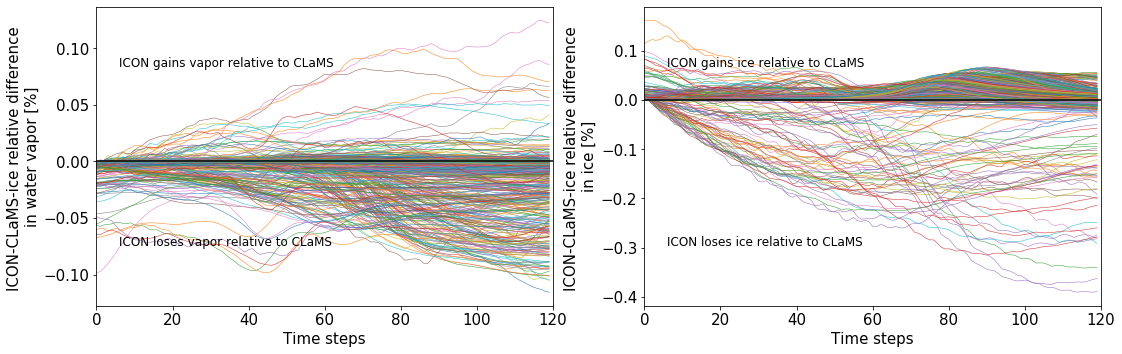

In [118]:
fs = 15
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,5.5))
for i in np.arange(2500):
    #if(icon_qv_cubic[0,i] > 0.0025*10**(-3)):
    ax[0].plot((icon_qv_cubic[:,i] - clams_qv[:,i])/clams_qv[:,i]*100.,lw=0.5,label='__nolabel__')

ax[0].plot([0,120],[0,0],color='k',lw=1.5)
ax[0].text(0.05,0.8,'ICON gains vapor relative to CLaMS',fontsize=12,transform=ax[0].transAxes)
ax[0].text(0.05,0.2,'ICON loses vapor relative to CLaMS',fontsize=12,transform=ax[0].transAxes)
ax[0].tick_params('both',labelsize=fs)
ax[0].set_xlim([0,120])
ax[0].set_ylim([-50,50])
ax[0].set_xlabel('Time steps',fontsize=fs)
ax[0].set_ylabel('ICON-CLaMS-ice relative difference '
           '\n'
           'in water vapor [%]',fontsize=fs)

for i in np.arange(5000):
    ax[1].plot((icon_qi_cubic[:,i] - clams_qi[:,i])/clams_qi[:,i]*100.,lw=0.5,label='__nolabel__')

ax[1].plot([0,120],[0,0],color='k',lw=1.5)
ax[1].text(0.05,0.8,'ICON gains ice relative to CLaMS',fontsize=12,transform=ax[1].transAxes)
ax[1].text(0.05,0.2,'ICON loses ice relative to CLaMS',fontsize=12,transform=ax[1].transAxes)
ax[1].tick_params('both',labelsize=fs)
ax[1].set_xlim([0,120])
ax[1].set_ylim([-100,150])
ax[1].set_xlabel('Time steps',fontsize=fs)
ax[1].set_ylabel('ICON-CLaMS-ice relative difference '
           '\n'
           'in ice [%]',fontsize=fs)
#fig.savefig('../output/qv-qi-RelDiff5.png',bbox_inches='tight')

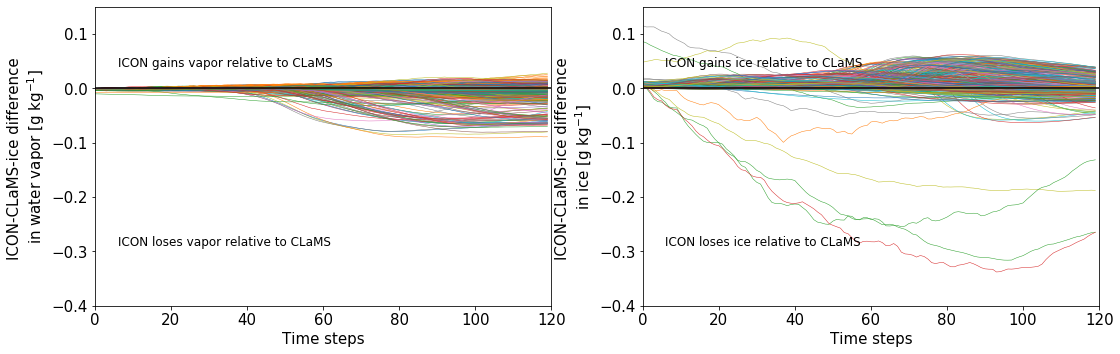

In [15]:
fs = 15
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,5.5))
for i in np.arange(2500):
    #if(icon_qv_cubic[0,i] > 0.0025*10**(-3)):
    ax[0].plot((icon_qv_cubic[:,i] - clams_qv[:,i])*10**3,lw=0.5,label='__nolabel__')
    #if()

ax[0].plot([0,120],[0,0],color='k',lw=1.5)
ax[0].text(0.05,0.8,'ICON gains vapor relative to CLaMS',fontsize=12,transform=ax[0].transAxes)
ax[0].text(0.05,0.2,'ICON loses vapor relative to CLaMS',fontsize=12,transform=ax[0].transAxes)
ax[0].tick_params('both',labelsize=fs)
ax[0].set_xlim([0,120])
ax[0].set_ylim([-0.4,0.15])
ax[0].set_xlabel('Time steps',fontsize=fs)
ax[0].set_ylabel('ICON-CLaMS-ice difference '
           '\n'
           'in water vapor [g kg$^{-1}$]',fontsize=fs)

for i in np.arange(5000):
    ax[1].plot((icon_qi_cubic[:,i] - clams_qi[:,i])*10**3,lw=0.5,label='__nolabel__')

ax[1].plot([0,120],[0,0],color='k',lw=1.5)
ax[1].text(0.05,0.8,'ICON gains ice relative to CLaMS',fontsize=12,transform=ax[1].transAxes)
ax[1].text(0.05,0.2,'ICON loses ice relative to CLaMS',fontsize=12,transform=ax[1].transAxes)
ax[1].tick_params('both',labelsize=fs)
ax[1].set_xlim([0,120])
ax[1].set_ylim([-0.4,0.15])
ax[1].set_xlabel('Time steps',fontsize=fs)
ax[1].set_ylabel('ICON-CLaMS-ice difference '
           '\n'
           'in ice [g kg$^{-1}$]',fontsize=fs)
fig.savefig('../output/qv-qi-AbsDiff4.png',bbox_inches='tight')